
 #### Predicting the number of bicycle trips across Seattle's Fremont Brige using Linear Regression

In [62]:
import pandas as pd
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('1404899.csv', index_col='DATE', parse_dates=True)

In [10]:
daily = counts.resample('d').agg('sum')
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # removing other columns

In [12]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float) # assiging a float day of week for one hot encoding

In [24]:
# adding weekend information to account for riders behaving differently on holidays

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)
daily

/var/folders/kc/4kd0hqq50fzggd1t6ntbxd8r0000gn/T/ipykernel_40433/328560785.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily['holiday'].fillna(0, inplace=True)


,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
2018-06-26,4771.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-27,4942.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2018-06-28,4387.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


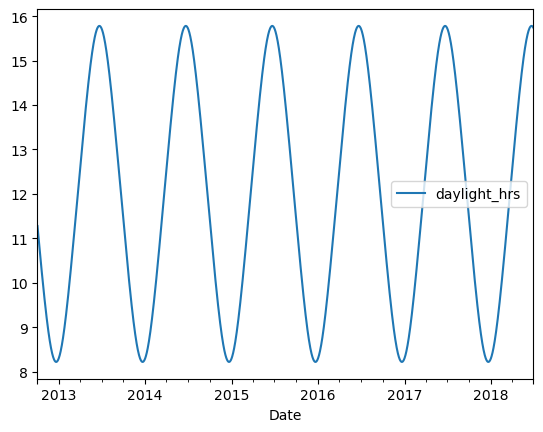

In [58]:
# accounting daylight hours using standard astronomical calculations

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - datetime(2000, 12, 21)).days
    m = (1 - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot();

In [63]:
#adding avg temp and total precipitation
# temperatures are in 1/10 deg C, convert to deg C

weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [65]:
# adding an annual counter to measure any observed annual increase or decrease in daily crossings

daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [67]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,5.60,1,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,5.65,1,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,5.95,1,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,6.05,1,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,6.05,1,0.010959


In [71]:
from sklearn.linear_model import LinearRegression

In [73]:
X = daily.drop('Total', axis=1)
y = daily['Total']

model = LinearRegression(fit_intercept=False) # fit intercept is false because atleast one of the day columns will be non zero
model.fit(X, y)
daily['predicted'] = model.predict(X)

In [75]:
daily.sample(10)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Date,,,,,,,,,,,,,,,
2014-09-10,4015.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.657022,0.000000,6.30,1,1.936986,4029.677745
2015-03-03,2945.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.843930,0.000000,4.15,1,2.413699,2977.714668
2015-07-17,3813.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,15.376320,0.000000,6.95,1,2.786301,4157.809715
2016-04-17,2223.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.502720,0.000000,6.40,1,3.539726,2332.371074
2017-06-14,4399.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15.741515,0.000000,5.80,1,4.698630,4274.642456
2013-08-08,4275.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14.454047,0.000000,7.05,1,0.846575,4345.344360
2013-09-22,796.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.937421,0.002087,5.95,0,0.969863,1004.380764
2014-05-24,2155.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15.243562,0.000000,5.85,1,1.638356,2320.124954
2015-01-04,339.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.341865,0.001575,4.45,0,2.254795,118.083281


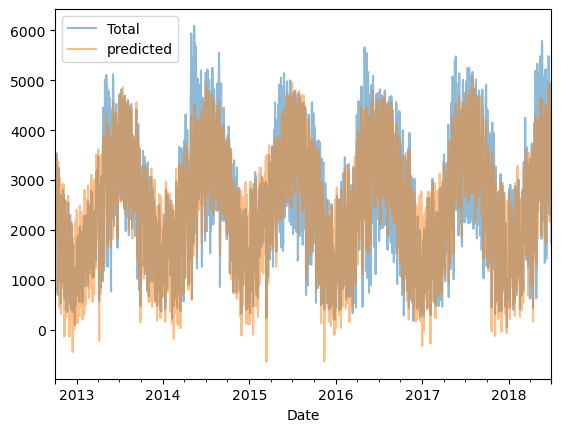

In [74]:
# comparing the total and predicted bicycle traffic visually

daily[['Total', 'predicted']].plot(alpha=0.5);

In [76]:
# taking a look at the coefficients
params = pd.Series(model.coef_, index=X.columns)
params

Mon               -730.428976
Tue               -542.880023
Wed               -553.300962
Thu               -709.947247
Fri              -1028.879884
Sat              -2366.417083
Sun              -2442.750129
holiday          -1130.052104
daylight_hrs       114.478986
PRCP           -174162.487714
Temp (C)           405.174729
dry day            515.174055
annual              34.197892
dtype: float64